# Business Context

** Desafio **
Criar um modelo de alta performance na identificação de clientes em churn.

Sobre a Empresa:
A TopBottonBank é um novo banco com atuação na europa.
 
**Entregável:**
Ao final da sua consultoria, você precisa entregar ao CEO da TopBottomBank um modelo em produção, que receberá uma base de clientes via API e desenvolverá essa base “scorada”, ou seja, um coluna à mais com a probabilidade de cada cliente entrar em churn.

Perguntas a serem respondidas no report final:
1-Qual a taxa de Churn atual da empresa?
2-Como a taxa de Churn varia por mês?
3-Qual a Performance do modelo em classificar os clientes como churns?
4-Qual o Faturamento da empresa, se ela impedir que os clientes de entrar em Churn através do seu modelo?
5-Qual o valor de um cupom de desconto você daria para o cliente, a fim de evitar churn? E qual o custo total desse incentivo para a empresa?

**Index:**
 - 1.0 Problema de Negócio
 - 1.1 Importações de bibliotecas
 - 2.0 Coleta de Dados
 - 3.0 Descrição dos Dados
 - 4.0 Limpeza de dados
 - 5.0 Feature Engineering
 - 6.0 EDA
 - 7.0 Data Preparation
 - 8.0 Feature Selection
 - 9.0 Model Selection
 - 10.0 Tunning/Treinamento do modelo
 - 11.0 API
 
**Estrátegia:**

3.0 Coleta de Dados:
Coletar os dados utilizando pd.read_csv().

4.0 Descrição dos Dados:
- Descrever as seguintes infos por feature: percentual de missing, valores únicos,     percentual de valores únicos, tipos de dados, skew, kurtosis.
- Descrever Gender vs Exited.
- Descrever Geography vs Exited.
- Descrever HasCrCard vs Exited 
- Descrever IsActiveMember vs Exited
- Descrever a variável 'type' com relação ao target.
- Descrever outras variáveis conforme for pertinente.
- Investigar a presença de Outliers.

5.0 Limpeza de dados:
- Investigar e eliminar os outliers


6.0 Feature Engineering

7.0 EDA

8.0 Teste de Hipoteses

9.0 Split Data

10.0 Data Preparation

11.0 Balanciamento dos Dados

12.0 Feature Selection

13.0 Model Selection

14.0 Tunning/Treinamento do modelo

15.0 API

# Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

# Models
import lightgbm as lgb
from BorutaShap import BorutaShap
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, precision_score, f1_score, recall_score

## Helper Functions

In [51]:
def multi_boxplots(df, variables: list) -> None:

    """
    Function to check for outliers visually through a boxplot

    data: DataFrame

    variable: list of numerical variables
    """

    # set of initial plot posistion
    n = 1

    plt.figure(figsize=(18, 10))
    for column in df[variables].columns:
        plt.subplot(3, 3, n)
        _ = sns.boxplot(x=column, data=df)
        n += 1

    plt.subplots_adjust(hspace=0.3)

    plt.show()
    
def Myheat_map(dataset, variaveis):

    df_corr = dataset[variaveis].corr()

    fig, ax = plt.subplots(figsize=(16, 10))
    # mask
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
    # adjust mask and df
    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()
    # color map
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

    # plot heatmap
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
                   linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
                   cbar_kws={"shrink": .8}, square=True)
    yticks = [i.upper() for i in corr.index]
    xticks = [i.upper() for i in corr.columns]
    plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
    plt.xticks(plt.xticks()[0], labels=xticks, rotation=20)

    # title
    title = 'CORRELATION MATRIX\n'
    plt.title(title, loc='left', fontsize=18)
    plt.show()

def cramer_v(var_x, var_y):
    """
    Function to calculate the Cramers v correlation.

    """
    # builds contigency matrix (or confusion matrix)
    confusion_matrix_v = pd.crosstab(var_x, var_y).values

    # gets the sum of all values in the matrix
    n = confusion_matrix_v.sum()

    # gets the rows, cols
    r, k = confusion_matrix_v.shape

    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix_v)[0]

    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)

    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

def model_selection(X,y):
    
    # Modelos
    models = [('lr',LogisticRegression()),
              ('knn',KNeighborsClassifier()),
              ('svm',SVC()),
              ('dt',DecisionTreeClassifier()),
              ('rf', RandomForestClassifier()),
              ('lgb',lgb.LGBMClassifier()),
              ('xgboost', XGBClassifier())]

    # Resultados
    resultados = {'LR': [],
                  'KNN': [],
                  'SVM': [],
                  'DecisionTree': [],
                  'RandomForestClassifier': [],
                  'LGBM': [],
                  'XGBOOST': []}

    # Testando algoritmos
    for name, model in models:
        

        # cross-validação
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        
        # resultado
        resultado = cross_val_score(estimator=model,
                                    X=X,
                                    y=y,
                                    scoring='f1',
                                    cv=cv,
                                    n_jobs=-1)

        if name == 'lr':
            resultados['LR'].append(np.mean(resultado))
        elif name == 'knn':
            resultados['KNN'].append(np.mean(resultado)) 
        elif name == 'svm':
            resultados['SVM'].append(np.mean(resultado))
        elif name == 'dt':
            resultados['DecisionTree'].append(np.mean(resultado))
        elif name == 'rf':
            resultados['RandomForestClassifier'].append(np.mean(resultado))
        elif name == 'lgb':
            resultados['LGBM'].append(np.mean(resultado))
        elif name == 'xgboost':
            resultados['XGBOOST'].append(np.mean(resultado))

    # Painel
    resultados_df = pd.DataFrame(resultados)
    return resultados_df

# Data Colection

In [2]:
churn = pd.read_csv('data/churn.csv')
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data Description

**Book de Variáveis:**

Age: Idade do cliente.

Balance: Quantidade de dinheiro na

CreditScore: Score de crédito do cliente.

CustomerId: Identificador unico do cliente.

EstimatedSalary: Salário estimado do cliente.

Exited: Variável target se ocorreu ou não churn do cliente.

Gender: Genêro do cliente.

Geography: Localizaçao do cliente.

HasCrCard: Flag se o cliente possui um cartão de crédito ou não

IsActiveMember: Flag se o cliente é ativo ou não.

RowNumber: Número da linha no dataset.

Surname: Sobrenome do cliente.

Ternure: Quantidade em anos que o cliente ainda está no banco ( no-churn ) e ela também diz quanto tempo o cliente ficou no banco até o churn.

In [ ]:
# Describe
pd.DataFrame({'missing' :churn.isna().mean(),
              'uniques' :churn.nunique(),
              'dtypes'  :churn.dtypes,
              'min'     :churn.min(),
              'mean'    :churn.mean(),
              'median'  :churn.median(),
              'max'     :churn.max(),
              'skew'    :churn.skew(),
              'kurtosis':churn.kurtosis()})

 - Temos dados de diferentes escalas
 - 'Customerid' e 'RowNumber' é um idientificador único podemos eliminar ou utiliza-lo como index do dataframe.
 - As variáveis 'HasCrCard' 'IsActiveMember' são categoricas ordinais iremos alterar o seu tipo para category.

## Target - Exited

In [ ]:
# Checkando o balanciamento da variável Target
ax = sns.countplot(x='Exited', hue=None, data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('Exited', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

- Podemos observar que as classes da variável Target esta desbalanciada.

## Descrever Gender vs Exited

In [ ]:
ax = sns.countplot(x='Gender', hue='Exited', data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('Gender', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

 - Aparentemente não existe uma concentração do evento de 'Churn' conforme o genero.

## Descrever Geography vs Exited

In [ ]:
ax = sns.countplot(x='Geography', hue='Exited', data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('Geography', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [ ]:
# Percentual de observações por valores Geography
churn.groupby('Geography').count()['RowNumber'].apply(lambda x: (x/churn.shape[0])*100)

- Notamos que proporcionalmente parece ocorrer um maior churn de clientes da Alemanha. A mesma possui comente 25% das observações porém possui mais eventos churn que as demais categorias.

## Descrever HasCrCard vs Exited

In [ ]:
ax = sns.countplot(x='HasCrCard', hue='Exited', data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('HasCrCard', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [ ]:
# Percentual de observações por valores HasCrCard
churn.groupby('HasCrCard').count()['RowNumber'].apply(lambda x: (x/churn.shape[0])*100)

- Devido a maior concentração de obseravções com cartão de credito temos também maior numero de eventos de churn.

## Descrever IsActiveMember vs Exited

In [ ]:
ax = sns.countplot(x='IsActiveMember', hue='Exited', data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('IsActiveMember', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [ ]:
# Percentual de observações por valores HasCrCard
churn.groupby('IsActiveMember').count()['RowNumber'].apply(lambda x: (x/churn.shape[0])*100)

 - Em um primeiro momento notamos que a inatividade leva a um maior churn. Os eventos estão distribuídos porém com maior quantidade de eventos de churn na categoria de inatividade.

## Alterando os tipos das variáveis 'HasCrCard', 'IsActiveMember', Exited

In [ ]:
# Alterando o tipo de dados para category
colunas = ['HasCrCard','IsActiveMember', 'Exited', 'Surname', 'Geography','Gender']

for col in colunas:
    churn[col] = churn[col].astype('category')

In [ ]:
# checkando os tipos
churn.dtypes

## Checkando a Presença de Outliers

In [ ]:
# Variáveis
variables = churn.select_dtypes(['int64', 'float64']).columns.to_list()

# Setando a posicão inicial
n = 1

plt.figure(figsize=(18, 10))
for column in churn[variables].columns:
    plt.subplot(4, 4, n)
    _ = sns.boxplot(x=column, data=churn)
    n += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

 - Observamos Outliers nas variáveis 'CreditScore', 'Age','NumOfProducts'

### CreditScore

In [ ]:
# Calculando o Q1 e Q3 e IQR
Q1 = np.quantile(churn['CreditScore'], .25)
Q3 = np.quantile(churn['CreditScore'], .75)
IQR = Q3 - Q1

# Calculando os limites low and high
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

# priting the limits
print(f'O limite inferior é {low}')
print(f'O limite superior é {high}')

 - Filtrando somente o limite inferior, pois no boxplot observamos outliers somente no limite inferior.

### Age

In [ ]:
# Calculando o Q1 e Q3 e IQR
Q1 = np.quantile(churn['Age'], .25)
Q3 = np.quantile(churn['Age'], .75)
IQR = Q3 - Q1

# Calculando os limites low and high
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

# priting the limits
print(f'O limite inferior é {low}')
print(f'O limite superior é {high}')

 - Filtrando somente o limite superior, pois no boxplot observamos outliers somente no limite superior.

### NumOfProducts

Iremos filtrar todas as observações com 4 produtos, pois conforme o boxplot os outliers estão nesse patamar.

# Limpeza de Dados

 ## Cleaning Outliers.

In [ ]:
# Filtrando 'CreditScore' somente o limite inferior.
churn = churn.loc[churn['CreditScore']>400, ]

# Filtrando 'Age' somente o limite inferior
churn = churn.loc[churn['Age']<59, ]

# Filtrando 'NumOfProducts'
churn = churn.loc[churn['NumOfProducts']<4, ]

In [ ]:
# checking the outliers again.
# Variáveis
variables = churn.select_dtypes(['int64', 'float64']).columns.to_list()

# Setando a posicão inicial
n = 1

plt.figure(figsize=(18, 10))
for column in churn[variables].columns:
    plt.subplot(4, 4, n)
    _ = sns.boxplot(x=column, data=churn)
    n += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

# Feature Engineering

- Eliminar as variáveis RowNumber, CustomersId, Surname(granularidade alta) por apresentarem pouco ganho de informação para a modelagem do nosso problema.
- Criar variável com Kmeans usando k=2. O valor de k é devido a estarmos trabalhando com um problema binário.
- Criar variável EstimatedSalary por location. Distribuição da renda podem nos ajudar na modelagem do problema.
- Binning as variáveis CreditScore, Age, Tenure, Balance, EstimatedSalary. Realizando o Binning dessas variáveis diminuimos a granularidade das mesmas o que irá facilitar a modelagem do problema futuramente.

In [35]:
# Copia do dataset original
dataset = churn.copy()

In [36]:
# Eliminando RowNumber, CustomersId, Surname(granularidade alta)
dataset.drop(['RowNumber','CustomerId','Surname'], inplace=True, axis=1)

In [37]:
# Variável kmeans distancia eucliadiana
# Criando copia
churn_temp = dataset.copy()

# Encoder
enc = OrdinalEncoder()
churn_temp['Gender'] = churn_temp['Gender'].apply(lambda x: 1 if x == 'Female' else 0)
churn_temp['Geography'] = enc.fit_transform(np.array(churn_temp['Geography']).reshape(-1,1))

# kmeans model
model = KMeans(n_clusters=2,init='k-means++')
model.fit(churn_temp)
dataset['kmeans_group'] = model.labels_
dataset['kmeans_group'] = dataset['kmeans_group'].astype('category')
dataset['kmeans_group'] = dataset['kmeans_group'].apply(lambda x: 'G1' if x==1 else 'G2')

In [38]:
# Criar variável Balance por location
group_balance = dataset.groupby('Geography').agg({'Balance': ['mean']}).reset_index()
group = pd.concat([group_balance['Geography'],group_balance['Balance']['mean']], axis=1)
dataset = dataset.merge(group, left_on='Geography', right_on='Geography', how='inner')

In [39]:
# Criar variável EstimatedSalary por location
group_balance = dataset.groupby('Geography').agg({'EstimatedSalary': ['mean']}).reset_index()
group = pd.concat([group_balance['Geography'],  group_balance['EstimatedSalary']['mean']], axis=1)
dataset = dataset.merge(group, left_on='Geography', right_on='Geography', how='inner')

In [40]:
# Binning
# CreditScore
dataset['CreditScore_new'] = pd.qcut(dataset['CreditScore'],q=10, labels=['G1','G2','G3','G4','G5','G6','G7','G8','G9','G10'])

# Age
dataset['Age_new'] = pd.qcut(dataset['Age'],q=10, labels=['G1','G2','G3','G4','G5','G6','G7','G8','G9','G10'])

# Tenure
dataset['Tenure_new'] = pd.qcut(dataset['Tenure'],q=10, labels=['G1','G2','G3','G4','G5','G6','G7','G8','G9','G10'])

# Balance
dataset['Balance_new'] = pd.qcut(dataset['Balance'],q=[.35, .70, 1], labels = ['G1','G2'])

# EstimatedSalary
dataset['EstimatedSalary_new'] = pd.qcut(dataset['EstimatedSalary'],q=10, labels=['G1','G2','G3','G4','G5','G6','G7','G8','G9','G10'])

In [41]:
# LTV
balance = dataset['Balance'].astype('int64')
dataset['LTV'] = balance / (dataset['Tenure'] + 0.1)

In [42]:
# Dando uma olhada como ficou o dataset
dataset.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,kmeans_group,mean_x,mean_y,CreditScore_new,Age_new,Tenure_new,Balance_new,EstimatedSalary_new,LTV
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,G2,62092.636516,99899.180814,G4,G7,G2,G1,G6,0.000000
1,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,G1,62092.636516,99899.180814,G1,G7,G8,G2,G6,19711.111111
2,699,France,Female,39,1,0.00,2,0,0,93826.63,0,G2,62092.636516,99899.180814,G7,G6,G1,G1,G5,0.000000
3,822,France,Male,50,7,0.00,2,1,1,10062.80,0,G2,62092.636516,99899.180814,G10,G9,G7,G1,G1,0.000000
4,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,G1,62092.636516,99899.180814,G1,G8,G4,G2,G4,34646.585366


# EDA

## Análise Univariada

### Category variables

In [ ]:
# checking the outliers again.
# Variáveis
variables = dataset.select_dtypes(['category']).columns.to_list()

# Setando a posicão inicial
n = 1

plt.figure(figsize=(36, 32))
for column in dataset[variables].columns:
    plt.subplot(4, 4, n)
    _ = sns.countplot(y=column,hue='Exited', data=dataset)
    n += 1

plt.subplots_adjust(hspace=0.6,wspace=0.5)
plt.show()

- Os casos de churn paracem diminuir a medida que aumenta a variável 'Ternure'
- Os casos de churn parecem aumentar a medida que a idade dos clientes também aumenta.
- Outro ponto parece haver um maior concetração de churn entre os clientes que não estão ativos.

### Numerical variables

In [ ]:
# Antes do feature eng
variables = dataset.select_dtypes(['int64','float64']).columns.to_list()
#variables.remove('RowNumber'), variables.remove('CustomerId')

# Setando a posicão inicial
n = 1

plt.figure(figsize=(36, 32))
for column in dataset[variables].columns[:len(variables)-1]:
    plt.subplot(4, 4, n)
    _ = sns.histplot(data = dataset, x=column, hue='Exited')
    n += 1

plt.subplots_adjust(hspace=0.6,wspace=0.5)
plt.show()

- Confirmamos a tendência de maior churn entre clientes com maior idade.
- Observamos também muitos clientes com 'balance' igual a zero, porém seme uma concetração atipica de casos de churn
- Distribuições proximas da normal com um skew fraco.

In [ ]:
# LTV
LTV = dataset.loc[(dataset['LTV'] != 0) & (dataset['LTV'] < (0.3*1000000)),]

plt.figure(figsize=(10, 8))
sns.histplot(data = LTV, x='LTV', hue='Exited')
plt.show()

- Distribuição com forte skew. Iremos proceder com normalização dos dados na etapa de Feature Eng.

## Análise Multivariada

In [ ]:
# Variáveis
variables = dataset.select_dtypes(['int64','float64']).columns.to_list()
variables.append('Exited')

sns.pairplot(dataset[variables], hue='Exited')

- Não é possível observar nenhuma relação linear entre as variáveis.
- É possivel também notar uma concentração de casos de churn no NumOfProducts igual a 3. 

### Correlations

##### Variáveis Numericas

In [ ]:
# Pearson correlation Matrix
Myheat_map(dataset =dataset, variaveis=variables)

- Observamos uma grande correlação entre a variavel mean_Y e mean_X iremos excluir uma delas

In [ ]:
# Removendo a variável mean_x
variables.remove('mean_x')
Myheat_map(dataset =dataset, variaveis=variables)

In [ ]:
# Numericas com relação a target
variables = dataset.select_dtypes(['int64','float64']).columns.to_list()

# Correlações
corrs = [pointbiserialr(dataset['Exited'], dataset[var])[0] for var in variables]
df_corr = pd.DataFrame({'Exited': corrs}, index=variables)

# Plot Matrix
fig, ax = plt.subplots()
plt.subplot(1, 2, 1)
sns.heatmap(df_corr, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Pointbiserialr")

- Nenhuma variável com a correlação significante  com relação a variávl Target.

### Variáveis categoricas - cramers v

In [ ]:
# colunas
cols = dataset.select_dtypes(['category', 'object']).columns.to_list()

# Dicionário para registro das correlações
dictt = {
        'Geography': [],
        'Gender': [],
        'HasCrCard': [],
        'IsActiveMember': [],
        'Exited': [],
        'kmeans_group': [],
        'CreditScore_new': [],
        'Age_new': [],
        'Tenure_new': [],
        'Balance_new': [],
        'EstimatedSalary_new': [],
        'Exited': []
        }

for col in cols:
    for col1 in cols:
        corr = cramer_v(dataset[col], dataset[col1])
        dictt[col].append(corr)
        
# Matriz de Correlação
df_cramer1 = pd.DataFrame(dictt)
df_cramer1 = df_cramer1.set_index(df_cramer1.columns)

# HeatMap
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 6)

mask = np.triu(np.ones_like(df_cramer1, dtype=np.bool))
sns.heatmap(df_cramer1, mask=mask, linewidths=.5, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Cramér V")

- Não encontramos nenhuma variável com alta correlação. Estou considerando correlações acima de 0.6 seriam eliminadas.

# Teste de Hipoteses - **Não Feito**

# Split de Dados

In [43]:
# X e y
X = dataset.drop('Exited', axis=1)
y = dataset['Exited']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=1)

# Alterando os tipos da Geography e Gender
varr = ['Geography', 'Gender']
for var in varr:
    Xtrain[var] = Xtrain[var].astype('category')
    Xtest[var] = Xtest[var].astype('category')

# Alterando o tipo dos ys
ytrain = ytrain.astype('int64')
ytest = ytest.astype('int64')

# Data Preparation

In [44]:
# Ordinal Encoder
variaveis = ['Geography', 
             'Gender',
             'kmeans_group',
             'CreditScore_new', 	
             'Age_new', 	
             'Tenure_new', 	
             'Balance_new', 	
             'EstimatedSalary_new']

# Instanciando o Ordinal Encoder
enc = OrdinalEncoder()

for var in variaveis:
    Xtrain[var] = enc.fit_transform(np.array(Xtrain[var]).reshape(-1,1))
    Xtest[var] = enc.fit_transform(np.array(Xtest[var]).reshape(-1,1))

# RobustScaler
variaveis = ['CreditScore', 
             'Age', 
             'Tenure', 
             'Balance', 
             'NumOfProducts', 
             'EstimatedSalary', 
             'mean_x', 
             'mean_y',
             'LTV']

# Instanciando o Robust Scaler
scaler = RobustScaler()

for var in variaveis:
    Xtrain[var] = scaler.fit_transform(np.array(Xtrain[var]).reshape(-1,1))
    Xtest[var] = scaler.fit_transform(np.array(Xtest[var]).reshape(-1,1))

## Balanciamento dos dados

In [45]:
# Adicionando balanciamento de dados ao Pipeline

# Instanciando o balanciador
smt = SMOTETomek(sampling_strategy='minority' ,random_state=42)
Xtrain_smt, ytrain_smt = smt.fit_resample(Xtrain, ytrain)

<AxesSubplot:xlabel='Exited', ylabel='count'>

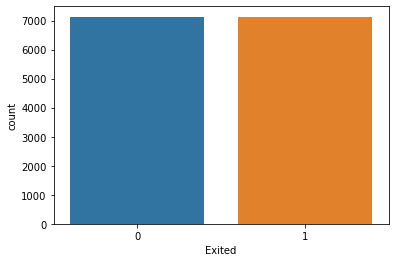

In [46]:
sns.countplot(x='Exited', data=pd.DataFrame(ytrain_smt))

# Feature Selection

In [48]:
# Modelo
model = lgb.LGBMClassifier()

#Selecionador de Features
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=True, )

Feature_Selector.fit(X=Xtrain_smt,y=ytrain_smt, n_trials=10, random_state=1)

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]

12 attributes confirmed important: ['IsActiveMember', 'Geography', 'EstimatedSalary_new', 'Age', 'mean_x', 'Gender', 'kmeans_group', 'Age_new', 'NumOfProducts', 'Balance_new', 'CreditScore', 'Balance']
1 attributes confirmed unimportant: ['EstimatedSalary']
6 tentative attributes remains: ['HasCrCard', 'mean_y', 'Tenure_new', 'Tenure', 'LTV', 'CreditScore_new']


In [49]:
# Visualizando as variáveis selecioandas
X_subset = Feature_Selector.Subset()
X_subset.head()

,IsActiveMember,Geography,EstimatedSalary_new,Age,mean_x,Gender,kmeans_group,Age_new,NumOfProducts,Balance_new,CreditScore,Balance
0,0,0.0,6.0,0.416667,0.0,0.0,1.0,7.0,3.0,0.0,-0.253731,-0.758829
1,0,0.0,6.0,-0.333333,0.0,1.0,0.0,3.0,0.0,1.0,-0.455224,0.274326
2,1,0.0,4.0,-0.500000,0.0,1.0,1.0,2.0,1.0,0.0,-1.343284,-0.298862
3,0,0.0,2.0,1.916667,0.0,0.0,0.0,1.0,0.0,0.0,1.089552,0.001389
4,1,1.0,1.0,-0.166667,1.0,1.0,1.0,4.0,0.0,0.0,0.059701,-0.299031


# Model Selection

Comparando as a performance dos modelos, utilizando todas as variáveis contra utilizando somente as variáveis selecionadas. Podemos observar que somente a Lightgbm obteve uma leve melhora com as variáveis selecionadas quanto os demais tiveram uma leve queda em seus f1 scores.

**--Vamos seguir com o modelo LGBM--**

A métrica base utilizada será o f1-score em conjunto com recall. A principal razão é por estarmos trabalhando com um problema de binário cujo o evento alvo é raro, dessa forma, queremos ter alta capacidade de detecção do evento alvo (recall) sem incorrer um muitos erros de previsão da classe negativa(F1 score nos ajuda nessa parte).

Lembrando
F1 score é média harmonica da recall e da precision.
Recall é a taxa de detecção de uma determinada classe.

## Com todas as variáveis

In [52]:
# Selicionando o modelo a ser trabalhado.
model_selection(Xtrain_smt, ytrain_smt)

,LR,KNN,SVM,DecisionTree,RandomForestClassifier,LGBM,XGBOOST
0,0.750809,0.844769,0.760728,0.862271,0.918109,0.910873,0.909518


## Com as variáveis selecionadas pelo Boruta.

In [54]:
# Selecionando o modelo a ser trabalhado
model_selection(X_subset, ytrain_smt)

,LR,KNN,SVM,DecisionTree,RandomForestClassifier,LGBM,XGBOOST
0,0.748646,0.842228,0.767796,0.862308,0.90752,0.909133,0.908933


# Tunning/Treinamento do modelo

O modelo escolhido foi a LGBM, abaixo um breve resumo.

** LGBM: **

O que é LGBM?

De acordo com a documentação adequada do LightGBM, é uma estrutura de aumento de gradiente que usa algoritmos de aprendizagem baseados em árvore. Ele é projetado para ser distribuído e eficiente com as seguintes vantagens:

- Maior velocidade de treinamento e maior eficiência.

- Menor uso de memória.

- Melhor precisão.

- Suporte para aprendizagem paralela e GPU.

- Capaz de lidar com dados em grande escala.

A principal diferença do LightGBM em comparação com outros algoritmos baseados em árvore é que ele faz a árvore crescer de forma vertical (folha) em vez de horizontal (nível). Ele escolherá a folha com perda máxima de delta para crescer e continuar crescendo a mesma folha; normalmente, um algoritmo Leaf-wise pode reduzir mais perdas do que um algoritmo-wise.

Os diagramas abaixo podem fornecer uma compreensão mais visual:

Restrições: Normalmente, o LightGBM não funciona bem em pequenos conjuntos de dados, não há limite formal aqui, mas 10.000 instâncias seria um bom número.

Parâmetros principais:

profundidade máxima,
boosting_type,
taxa de Aprendizagem,
n_estimators,
num_leaves,
subamostra,
min_split_gain,
min_split_weight,
min_child_samples.

In [ ]:
# Training LGBM

def train_lightGBM(X, y, n_iter, n_splits=10):
    
    # Transformador de Colunas
    ct = ColumnTransformer([("ordinal", OrdinalEncoder(), ['Geography','Gender','CreditScore_new', 'Age_new', 'Tenure_new', 'Balance_new','EstimatedSalary_new']),
                        ("scaler", RobustScaler(), ['CreditScore','Age','Tenure','Balance', 'NumOfProducts','EstimatedSalary','mean_y', 'LTV'])],remainder='passthrough')
    
    # Instanciando o balanciador
    smt = SMOTETomek(sampling_strategy='minority' ,random_state=42)
    
    # Preprocessing e modelo
    model = Pipeline([('ct',ct),
                      ('smt', smt),
                      ('model', lgb.LGBMClassifier())])
    

    # Dicionário de metricas
    resultados = {'ACC_MEAN': [],
                  'ACC_STD': [],
                  'KAPPA_MEAN': [],
                  'KAPPA_STD': [],
                  'RECALL_MEAN': [],
                  'RECALL_STD': [],
                  'F1_MEAN': [],
                  'F1_STD': [],
                  'PRECISION_MEAN': [],
                  'PRECISION_STD': [] }
    
    # cross-validiação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    # resultado
    acc = []
    kappa = []
    recall = []
    f1 = []
    precision = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        model.fit(X_treino, y_treino)
        pred = model.predict(X_valid)
        Acc = accuracy_score(y_valid, pred)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Recall = recall_score(y_valid, pred)
        F1 = f1_score(y_valid, pred)
        Precision = precision_score(y_valid, pred)
        acc.append(Acc)
        kappa.append(Kappa)
        recall.append(Recall)
        f1.append(F1)
        precision.append(Precision)
        
    # Treinando o modelo em todos os dados
    model = model.fit(X,y)
    
    # Salvando o modelo em pickle
    with open('models/modelo_base.pkl', 'wb') as f:
        pickle.dump(model, f)
        
    resultados['ACC_MEAN'].append(np.mean(acc))
    resultados['ACC_STD'].append(np.std(acc))
    resultados['KAPPA_MEAN'].append(np.mean(kappa))
    resultados['KAPPA_STD'].append(np.std(kappa))
    resultados['RECALL_MEAN'].append(np.mean(recall))
    resultados['RECALL_STD'].append(np.std(recall))
    resultados['F1_MEAN'].append(np.mean(f1))
    resultados['F1_STD'].append(np.std(f1))
    resultados['PRECISION_MEAN'].append(np.mean(precision))
    resultados['PRECISION_STD'].append(np.std(precision))
    
    print('####### Bussines Metrics #######')
    
    # Painel
    painel_df = pd.DataFrame(resultados).T
    return painel_df, model

painel, modelo_base = train_lightGBM(X=Xtrain, y=ytrain, n_iter=5)

In [ ]:
# Painel de metricas do modelo baseline(sem Tunning)
painel

## Tunning

In [ ]:
Xtrain.dtypes

In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid de Parametros
param_grid = {
              'learning_rate': [0.01, 0.1, 0.5, 1],
              'n_estimators': [100, 250, 500],
              'num_leaves': [10, 15, 31, 45],
              'min_child_samples' : [5,10,20]
             }

# cross-validiação
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

def tunnig_gridsearch(Xtrain, ytrain, model, param_grid, cv, scoring, refit):
    
#     # Transformador de Colunas
#     ct = ColumnTransformer([("ordinal", OrdinalEncoder(), ['Geography','Gender','CreditScore_new', 'Age_new', 'Tenure_new', 'Balance_new','EstimatedSalary_new']),
#                         ("scaler", RobustScaler(), ['CreditScore','Age','Tenure','Balance', 'NumOfProducts','EstimatedSalary','mean_y', 'LTV'])],remainder='passthrough')
    
#     # Preprocessing e modelo
#     prep_pipeline = Pipeline([('ct',ct),('smt', smt)])
                         
#     X = pd.DataFrame(prep_pipeline.fit_resample(Xtrain, ytrain)[0], columns=Xtrain.columns)
#     y = pd.DataFrame(prep_pipeline.fit_resample(Xtrain, ytrain)[1])
    
    search = GridSearchCV(estimator=model.named_steps['model'],
                          param_grid=param_grid,
                          scoring=scoring,
                          refit=refit,
                          cv=cv,
                          verbose=1,
                          n_jobs=-1)
    
    search.fit(Xtrain, ytrain)
    
    return search.best_params_, search.cv_results_

# Tunning
best_params, cv_results = tunnig_gridsearch(Xtrain=Xtrain,
                                             ytrain=ytrain,
                                             model=modelo_base,
                                             param_grid=param_grid,
                                             scoring='f1',
                                             refit='f1',
                                             cv=skf)

In [ ]:
# best parameters
best_params

In [ ]:
def train_tunned_lightGBM(X, y, 
                          learning_rate,
                          min_child_samples, 
                          n_estimators, 
                          num_leaves, 
                          n_iter, 
                          n_splits=10):
    
    # Transformador de Colunas
    ct = ColumnTransformer([("ordinal", OrdinalEncoder(), ['Geography','Gender','CreditScore_new', 'Age_new', 'Tenure_new', 'Balance_new','EstimatedSalary_new']),
                        ("scaler", RobustScaler(), ['CreditScore','Age','Tenure','Balance', 'NumOfProducts','EstimatedSalary','mean_y', 'LTV'])],remainder='passthrough')
    
    # Preprocessing e modelo
    prep_pipeline = Pipeline([('ct',ct),('smt', smt)])
    model = lgb.LGBMClassifier(objective='binary',
                               learning_rate = learning_rate,
                               min_child_samples = min_child_samples,
                               n_estimators = n_estimators,
                               num_leaves = num_leaves
                               )
                         
    X = pd.DataFrame(prep_pipeline.fit_resample(Xtrain, ytrain)[0], columns=Xtrain.columns)
    y = pd.DataFrame(prep_pipeline.fit_resample(Xtrain, ytrain)[1])

    # Dicionário de metricas
    resultados = {'ACC_MEAN': [],
                  'ACC_STD': [],
                  'KAPPA_MEAN': [],
                  'KAPPA_STD': [],
                  'RECALL_MEAN': [],
                  'RECALL_STD': [],
                  'F1_MEAN': [],
                  'F1_STD': [],
                  'PRECISION_MEAN': [],
                  'PRECISION_STD': [] }
    
    # cross-validiação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    # resultado
    acc = []
    kappa = []
    recall = []
    f1 = []
    precision = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        model.fit(X_treino, y_treino)
        pred = model.predict(X_valid)
        Acc = accuracy_score(y_valid, pred)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Recall = recall_score(y_valid, pred)
        F1 = f1_score(y_valid, pred)
        Precision = precision_score(y_valid, pred)
        acc.append(Acc)
        kappa.append(Kappa)
        recall.append(Recall)
        f1.append(F1)
        precision.append(Precision)

    resultados['ACC_MEAN'].append(np.mean(acc))
    resultados['ACC_STD'].append(np.std(acc))
    resultados['KAPPA_MEAN'].append(np.mean(kappa))
    resultados['KAPPA_STD'].append(np.std(kappa))
    resultados['RECALL_MEAN'].append(np.mean(recall))
    resultados['RECALL_STD'].append(np.std(recall))
    resultados['F1_MEAN'].append(np.mean(f1))
    resultados['F1_STD'].append(np.std(f1))
    resultados['PRECISION_MEAN'].append(np.mean(precision))
    resultados['PRECISION_STD'].append(np.std(precision))

    # retrain over all data
    model = model.fit(X, y)

    # Painel
    painel_df = pd.DataFrame(resultados).T
    return painel_df, model

# Treinando modelo tunnado
painel, modelo_tunned = train_tunned_lightGBM(X=Xtrain, 
                                       y=ytrain,learning_rate=best_params['learning_rate'],
                                                min_child_samples=best_params['min_child_samples'], 
                                                n_estimators=best_params['n_estimators'] , 
                                                num_leaves=best_params['num_leaves'],   
                                                n_iter=5)

# painel de metricas
painel

Observamos que o modelo base obteve melhor F1 score com o Recall se mantendo muito proximo. 
Dessa forma serguiremos como o modelo_base.

# Interpretação do Modelo

In [ ]:
# Importância das variáveis
from scikitplot.estimators import plot_feature_importances

# Variaveis
variaveis = Xtrain.columns.to_list()

plt.figure(figsize=(16, 10))
plot_feature_importances(model['model'], feature_names= variaveis, x_tick_rotation=90)
plt.show()

- Podemos observar que a variável LTV foi a variável mais relevante na modelagem do nosso problema. Sendo os 3 principais fatores abaixo:
       - Score de crédito do cliente.
       - E o life time value do cliente.
       - A idade do cliente.

In [ ]:
# Confusion Matrix
from scikitplot.metrics import plot_confusion_matrix

# Predictions
pred = model.predict(Xtest)

# Plot
plot_confusion_matrix(ytest, pred, normalize=True)

In [ ]:
# Learning Curves
from scikitplot.estimators import plot_learning_curve

#  Estrátegia de cross-validation 
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)


plot_learning_curve(model, Xtest, ytest, cv=skf, scoring='f1')
plt.show()

In [ ]:
# Shap values